In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from SceneR2.core import *
from SceneR2.learners import ModelLearner, ParallelLearner
from SceneR2.dataset import CANData, MovingObjectData, SingleCAN, MovingObjectData2
from SceneR2.dataset import *
from SceneR2.loss import weightedMSE
from SceneR2.utils.dataset import fig2rgb_array
from SceneR2.utils.dataset import vid_from_csv
import pickle

In [3]:
! which python

/home/sufiyan/anaconda3/envs/fastai/bin/python


As loading and cleaning the dataset takes some time, we load the dataset and save it in a pickle file to be loaded below. This makes the process of loading the dataset quicker the next time we run the model.

In [4]:
data=MovingObjectData2.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_cleaned_157_26Mar", 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 161/161 [01:43<00:00,  1.55it/s]


In [6]:
data=MovingObjectData2.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_4Jun", 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 161/161 [01:55<00:00,  1.39it/s]


Loading the dataset. To see how the dataset works, see [SceneR2/dataset.py](https://github.com/dumbPy/MTP/blob/master/SceneR2/dataset.py)

In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_4Jun", 'rb') as f:
    dataset=pickle.load(f)

[]
ABAReactionIndex:  96
ABAReactionStopIndex: 230
Edge_0:  []
Edge_1:  [203, 204]
Reason for Braking:  Driving/Moving Object
Label:  0
edgePostABA:  202


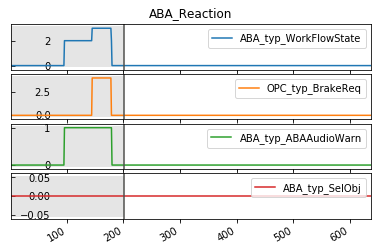

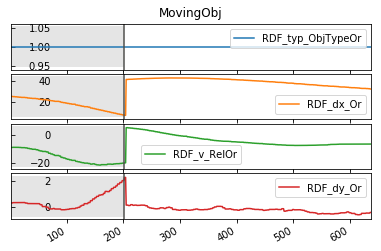

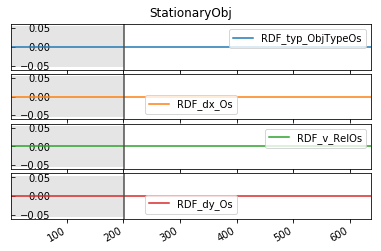

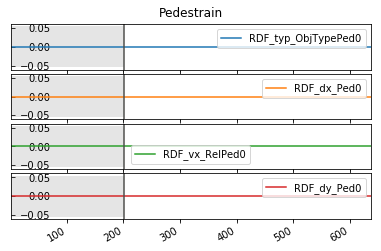

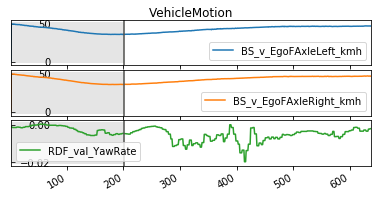

In [5]:
allaxes = dataset.plot(10, tight_layout=True, supressPostABA=False, all_columns=True, verbose=True)

In [6]:
dataset.play(10)

[]
ABAReactionIndex:  466
ABAReactionStopIndex: 606
Edge_0:  []
Edge_1:  [576, 577]
Reason for Braking:  Driving/Moving Object
Label:  0
edgePostABA:  576


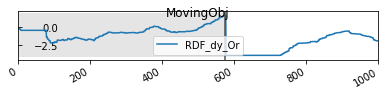

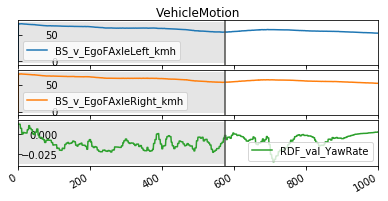

In [7]:
# Show only columns that are being used for training i.e., all_columns=False
all_axes=dataset.plot(1, supressPostABA=False, all_columns=False, verbose=True, tight_layout=True)

Total number of files in the dataset

In [8]:
len(dataset)

158

In [9]:
# tensor would have only 4 columns, 1 for y position of moving object (RDF_dy_Or) and 3 for VehicleMotion
dataset[0][0].shape

(552, 4)

Number of files for **Left**, **Right** and **Other** classes respectively. These include flipped files for Left and Right

In [10]:
print(len([1 for x,y in dataset if y==0]))
print(len([1 for x,y in dataset if y==1]))
print(len([1 for x,y in dataset if y==2]))

61
62
35


Seperating train and test files.

In [11]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

Defining the Dataloaders for training and validation data

In [12]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles])

In [43]:
test_dir_path = '../data/Daimler/100_vids/test_data/'
if os.path.exists(test_dir_path): 
    !rm -rf {test_dir_path}
os.makedirs(test_dir_path+'videos', exist_ok=True)
os.makedirs(test_dir_path+'can', exist_ok=True)
for i in testFiles:
    can_path = dataset.can[i]
    video_path = vid_from_csv(SingleCAN.get_file_id(dataset.can[i]))
    !cp {can_path} {test_dir_path+'can'}
    !cp {video_path} {test_dir_path+'videos'}

A simple model defined below is trained. It consists of a 2 Layer LSTM followed by a fully connected Layer

In [52]:
# also at SceneR2.models.CanModel
class CanModel(nn.Module):
    def __init__(self,categories=3, input_size=4, hidden_size=20, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x):
        x,_=self.l1(x)
        x=x[:,-1,:]
        x= self.l2(x)
        return x

ParallelLearner class takes ModelLearners that take models and other parameters like learning rate, optimization function and loss function.

In [13]:
from SceneR2.models import CanModel

In [21]:
learner=ParallelLearner(
                [ModelLearner(CanModel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.Adam, modelName='movingObjectDataModel' ),
                 ModelLearner(CanModel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                              optim=torch.optim.Adam, modelName='movingObjectDataModel' ),
                 ModelLearner(CanModel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,10]), 
                              optim=torch.optim.Adam, modelName='movingObjectDataModel' ),
                 ModelLearner(CanModel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,20]), 
                              optim=torch.optim.Adam, modelName='movingObjectDataModel' )
                ],epochs=100, trainLoader=trainLoader, validLoader=testLoader)

In [29]:
learner.train(50)

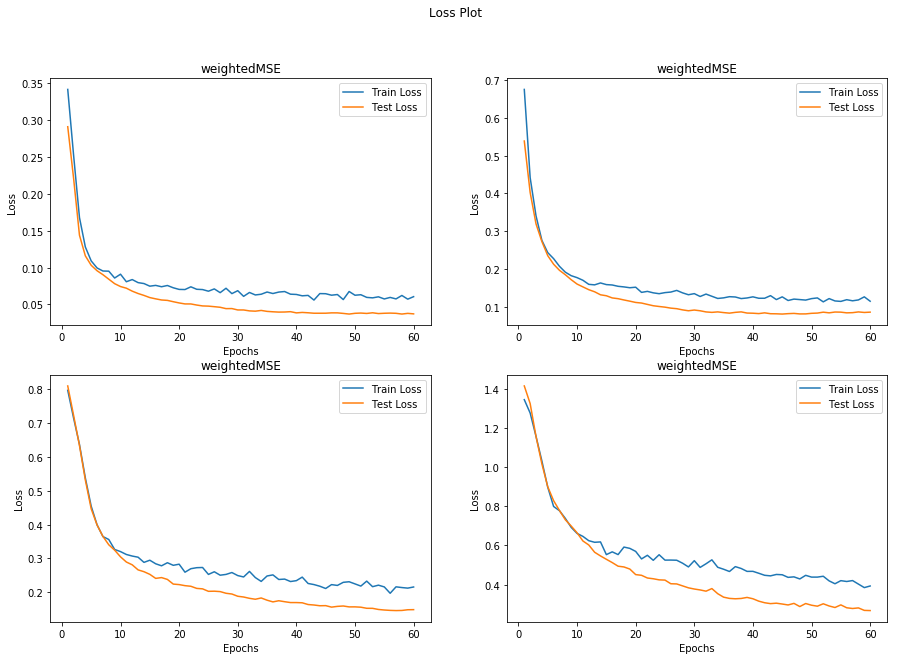

In [30]:
learner.plotLoss(figsize=(15,10))

In [31]:
learner.print_confusion_matrix(train=True)
print("\n")
learner.print_confusion_matrix(train=False)

weightedMSE
[[52  0  1]
 [ 0 49  0]
 [ 4  4 20]]
weightedMSE
[[52  0  1]
 [ 0 49  0]
 [ 4  4 20]]
weightedMSE
[[53  0  0]
 [ 0 48  1]
 [ 4  4 20]]
weightedMSE
[[52  0  1]
 [ 0 49  0]
 [ 4  4 20]]


weightedMSE
[[ 8  0  0]
 [ 0 13  0]
 [ 1  0  6]]
weightedMSE
[[ 8  0  0]
 [ 0 13  0]
 [ 1  0  6]]
weightedMSE
[[ 8  0  0]
 [ 0 13  0]
 [ 1  0  6]]
weightedMSE
[[ 8  0  0]
 [ 0 13  0]
 [ 1  0  6]]


In [32]:
learner.learners[2].save(path='../SceneR2/saved_models/CanModel_4Jun.pt')